In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import functools
from scipy.ndimage import gaussian_filter as gf

from xrdc import xrdutils as xdu


def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

In [2]:
# !pip install powerbox

In [3]:
from scipy.interpolate import NearestNDInterpolator

# plt.pcolormesh(X, Y, Z, shading='auto')
# plt.plot(x, y, "ok", label="input point")
# plt.legend()
# plt.colorbar()
# plt.axis("equal")
# plt.show()

/home/ollie/anaconda3/lib/python3.8/site-packages/pymatgen-2022.1.9-py3.8-linux-x86_64.egg/pymatgen/io/cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


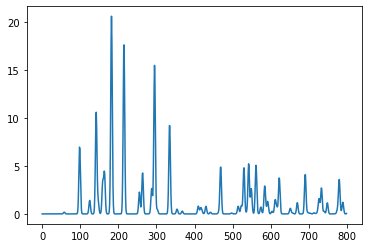

In [4]:
paths = glob("NbCoSn/*")

import pymatgen as pm
from pymatgen.analysis.diffraction.xrd import XRDCalculator

def get_structure(p):
    #p path to CIF
    structure = pm.core.Structure.from_file(p) #read in structure
    return structure

def structure_pat(structure, sigma = .01):
    xrd = XRDCalculator("CuKa") #initiate XRD calculator (can specify various options here)
    pat = xrd.get_pattern(structure)
    q, i = xdu.to_q(pat.x), pat.y
    ii = xdu.mk_pattern(i, q, sigma)
    return ii

# pat from cif path
get_pat = compose(structure_pat, get_structure)

structures = [get_structure(p) for p in paths]
pats = [get_pat(p) for p in paths]
pat= pats[1]

plt.plot(pats[1])

In [5]:
def _twotheta(x, y):
    return np.arccos((x * np.sin(alpha) + D * np.cos(alpha)) / np.sqrt(D**2 + x**2 + y**2))

def _phi(x, y):
    return (np.sign(x * np.cos(alpha) - D * np.sin(alpha)) * 
            np.arccos(-y / 
                np.sqrt(y**2 +
                    (x * np.cos(alpha) - D * np.sin(alpha))**2
                       )
                     ))

def interp2d(x, y, z):
    interp = NearestNDInterpolator(list(zip(x, y)), z)
    return interp

In [6]:
twotheta = xdu.to_twotheta(xdu.q_grid) * (np.pi / 180)

In [7]:
Nphi = 200

phi = np.linspace(-np.pi, np.pi, num = Nphi + 1)[1:]

tt, phiphi = np.meshgrid(twotheta, phi)
theta_phi_shape = tt.shape
tt, phiphi = tt.ravel(), phiphi.ravel()

II = np.hstack([pat for _ in range(theta_phi_shape[0])])

In [8]:
alpha, D = 0., 50

scale = 5
N = 100
dn = 1 / scale
offset = 0#1e-6

gridx = np.arange(-N, N, dn) + offset
gridy = np.arange(-N, N, dn) + offset

xx, yy = np.meshgrid(gridx, gridy)

tt_det = _twotheta(xx, yy)

phi_det = _phi(xx, yy)

In [9]:
# credit https://github.com/PabloVD/MapGenerator

import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
from scipy import interpolate, ndimage

#--- Parameters ---#

# Number of bins per dimension
boxsize = xx.shape[0] // 2
# Number of bins per dimension in the high resolution  box
highboxsize = 2*boxsize
# Threshold for the sea level
threshold = 0.52
# Sigma for the gaussian smoothing
sigma = 5. 
# Initial random seed
llavor = 0
# Spectral index for the power spectrum
indexlaw = -.4

# Define power spectrum as a power law with an spectral index indexlaw
# With lower the spectral indexes, small structures are removed
def powerspec(k,indexlaw):
    return k**indexlaw

# Filter the field with a gaussian window
def smooth_field(field,sigmagauss,gridsize=boxsize):

    x, y = np.linspace(0,field.shape[0],num=field.shape[0]), np.linspace(0,field.shape[1],num=field.shape[1])

    # Interpolation
    f = interpolate.interp2d(x,y,field,kind="linear")

    qx = np.linspace(x[0],x[-1], num = gridsize)
    qy = np.linspace(y[0],y[-1], num = gridsize)

    # Filtering
    smooth = ndimage.filters.gaussian_filter(f(qx,qy),sigmagauss)
    return smooth

# Remove regions below sea level
def mainland(field,threshold):
    for i, row in enumerate(field):
        for j, el in enumerate(row):
            if el<threshold:   field[i,j]=0.
    return field

# Normalize the values of the field between 0 and 1
def normalize_field(field):
    min, max = np.amin(field), np.amax(field)
    newfield = (field-min)/(max-min)
    return newfield

# Generate a map of islands applying different processes:
# 1. Generate a random gaussian field given a power spectrum
# 2. Normalize the field between 0 and 1
# 3. Smooth the field with a gaussian filter
# 4. Retain only the mainland above a certain threshold
def generate_map(llavor,indexlaw,sigma,threshold):
    np.random.seed(seed=llavor)
    field = pbox.powerbox.PowerBox(boxsize, lambda k: powerspec(k,indexlaw), dim=2, boxlength=100.).delta_x()
    field = normalize_field(field)
    field = smooth_field(field,sigma,gridsize=highboxsize)
    field = mainland(field,threshold)
    return field


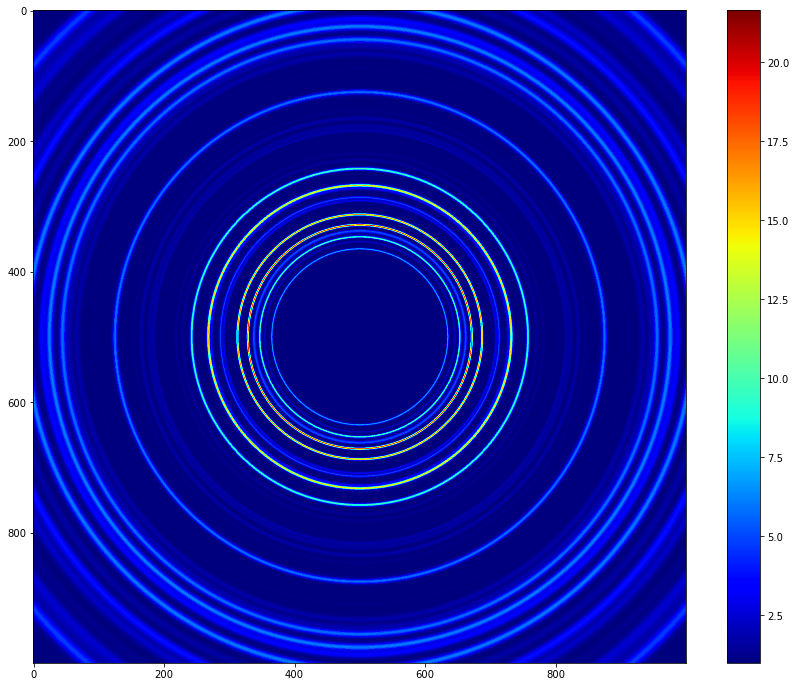

In [10]:
interp = interp2d(tt, phiphi, II)

detsignal = interp(tt_det, phi_det)

plt.rcParams["figure.figsize"]=(15, 12)
plt.imshow((1 + detsignal), cmap = 'jet')
plt.colorbar()

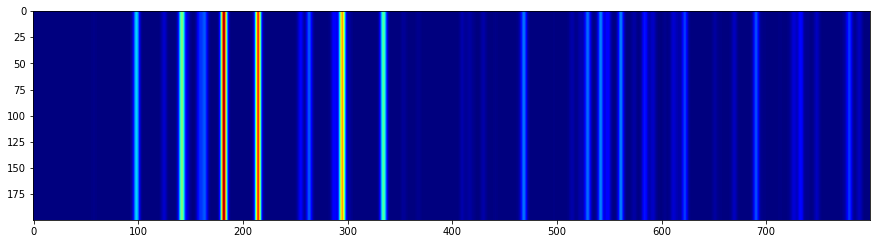

In [11]:
plt.imshow(II.reshape(theta_phi_shape), aspect = 1., cmap = 'jet')

/home/ollie/anaconda3/lib/python3.8/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


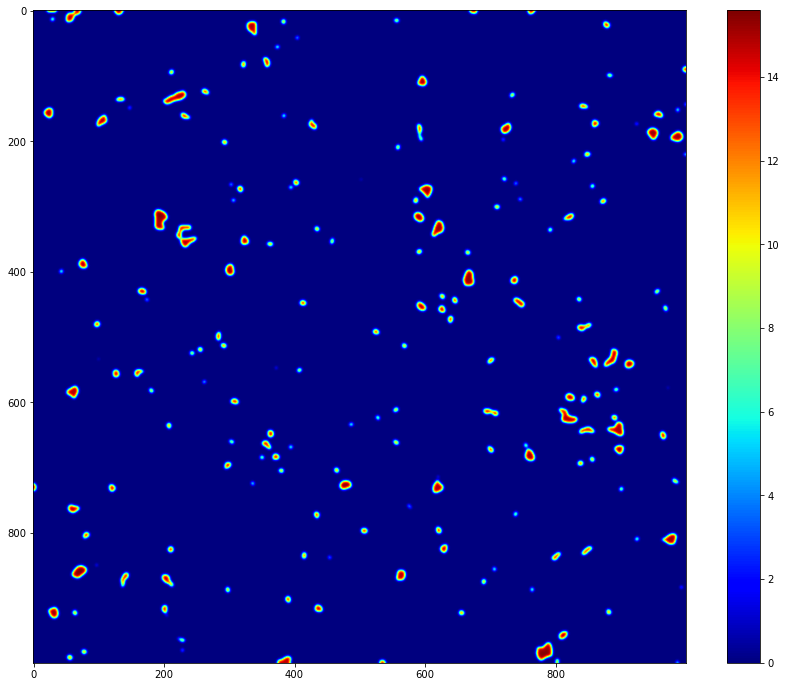

In [12]:
noise_scale = .2

splotches = generate_map(llavor,indexlaw,sigma,threshold)
splotches = gf(mainland(splotches, .04), 2)
splotches = noise_scale * splotches * (detsignal.mean() / splotches.mean())

plt.imshow(splotches, cmap = 'jet')
plt.colorbar()

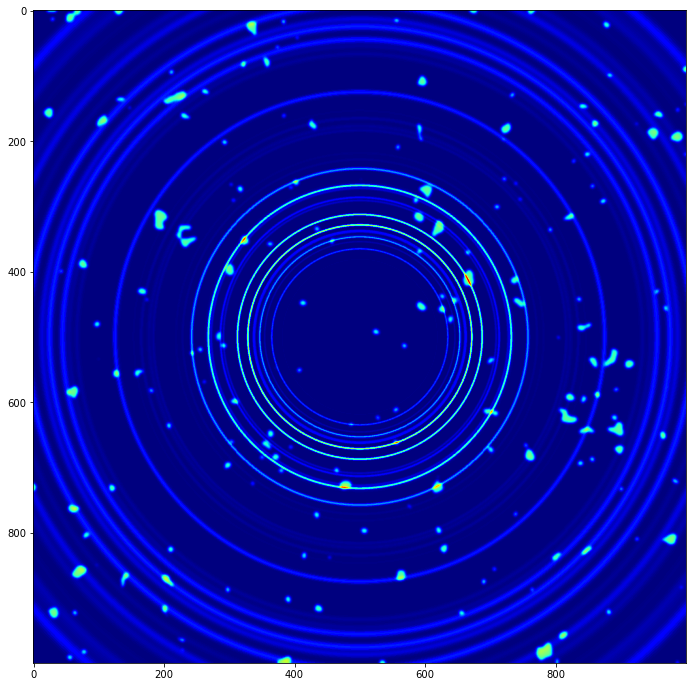

In [13]:
plt.imshow(detsignal + splotches, cmap = 'jet')

In [14]:
def mk_get_idx(min_twotheta, max_twotheta, Ntheta):
    def f(twotheta_nongrid):
        i = (((twotheta_nongrid - min_twotheta) / (max_twotheta - min_twotheta)) * Ntheta).astype(int)
        ref = np.ones_like(i)
        axis = 2

        amin = np.min(np.dstack([ref * (Ntheta - 1), i]), axis = axis)
        amax = np.max(np.dstack([0 * ref, amin]), axis = axis)
        return amax
    return f

min_twotheta = twotheta.min()
max_twotheta = twotheta.max()
Ntheta = len(twotheta)

_twotheta_idx = mk_get_idx(min_twotheta, max_twotheta, Ntheta)
    
min_phi = phi.min()
max_phi = phi.max()
_phi_idx = mk_get_idx(min_phi, max_phi, Nphi)

# from xrdc import geometry as geo

In [15]:
# %pdb

Test

In [16]:
_twotheta_idx(np.array([[1.111111, -100, 100], [1.111111, -100, 100]]))

array([[533,   0, 799],
       [533,   0, 799]])

In [17]:
_twotheta_idx(np.array([1.111111, -100, 100]))

array([[533,   0, 799]])

In [18]:
_phi_idx(np.array([1.111111, -100, 100]))

array([[135,   0, 199]])

In [19]:
twotheta_nongrid = _twotheta(xx, yy)
phi_nongrid = _phi(xx, yy)

Itheta_phi_full = II.reshape(theta_phi_shape)
noisemap = np.zeros_like(Itheta_phi_full)
sigmap = np.zeros_like(Itheta_phi_full)

itt = _twotheta_idx(twotheta_nongrid)

iphi = _phi_idx(phi_nongrid)

noisemap[iphi, itt] += splotches
sigmap[iphi, itt] += detsignal

Text(0, 0.5, 'phi')

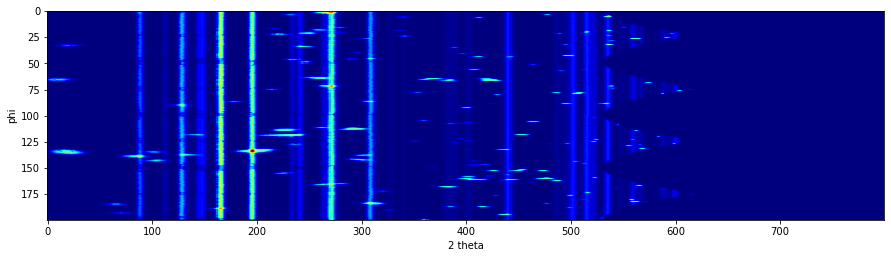

In [20]:
totalmap = sigmap + noisemap
patterns = totalmap

patterns = gf(patterns, (0.5, 1.))
#patterns = gf(patterns, (.5, 1.7))
plt.imshow(patterns, cmap = 'jet', aspect = 1, interpolation='none')
plt.xlabel('2 theta')
plt.ylabel('phi')

#plt.hlines(133, 0, 750)

In [21]:
from xrdc import source_separation as sep

In [22]:
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25, threshold = 20, smooth_q = 1.7, background_after_filter = False)
background = slow_q

(0, 0)


In [31]:
sep.iplot_rows(patterns, fast_T, labels = ['raw', 'fast T'])

interactive(children=(IntSlider(value=99, description='i', max=199), Output(layout=Layout(height='550px'))), _…

In [24]:
from importlib import reload
reload(sep)

<module 'xrdc.source_separation' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/source_separation.py'>

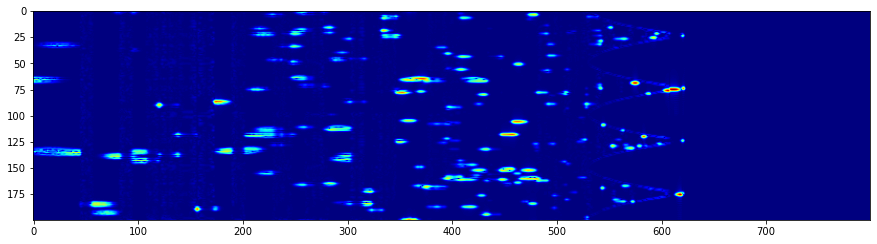

In [71]:
nthresh = 0.03
absnoise = np.abs(fast_T) / (np.abs(np.mean(patterns, axis = 0)) + 1e-6)
plt.imshow(np.log10(1 + absnoise), cmap = 'jet')

mask = gf(absnoise, (.5, 1)) > nthresh

In [65]:
reload(sep)

<module 'xrdc.source_separation' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/source_separation.py'>

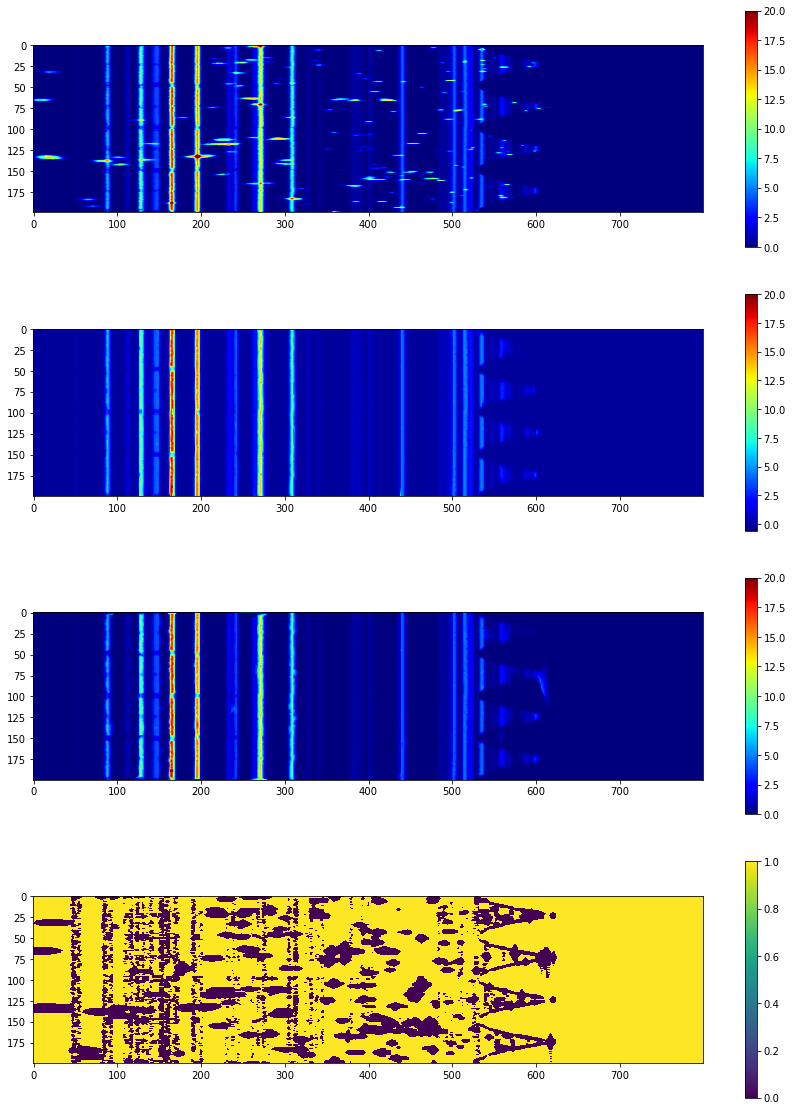

In [75]:
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"]=(15, 20)

a, b = 4, 1
plt.subplot(a, b, 1)
plt.imshow(patterns, cmap = 'jet', vmax = 20)
plt.colorbar()

denoised2 = sep.CTinterpolation((~mask) * patterns)

#denoised = sep.NDinterpolation((~mask) * patterns)

denoised = sep.interprows(gf(patterns, (0, 0)).T, (~mask).T, fill_value="extrapolate").T


plt.subplot(a, b, 2)
plt.imshow(denoised, cmap = 'jet', vmax = 20, interpolation = 'none')
plt.colorbar()

plt.subplot(a, b, 3)
plt.imshow(denoised2, cmap = 'jet', vmin = 0, vmax = 20, interpolation = 'none')
plt.colorbar()

plt.subplot(a, b, 4)
plt.imshow(((~mask)), interpolation = 'none')
plt.colorbar()

In [76]:
# remap the denoised data into detector space
ixx, iyy = np.indices(xx.shape)

detremap = np.zeros(xx.shape)

detremap[ixx, iyy] += denoised[iphi, itt]

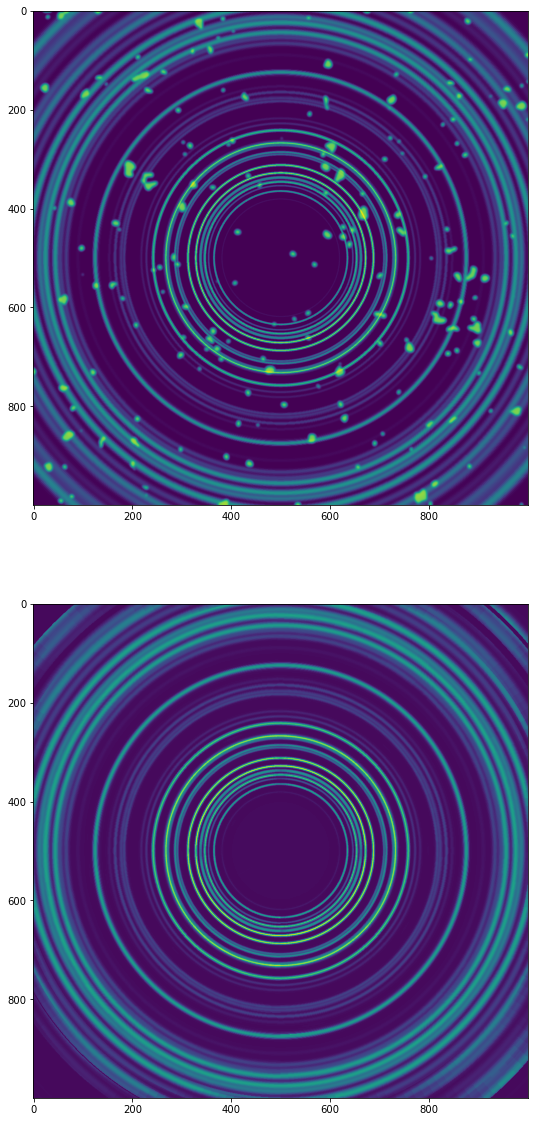

In [77]:
plt.rcParams["figure.figsize"]=(15, 20)

a, b = 2, 1

plt.subplot(a, b, 1)
plt.imshow(np.log(1 + detsignal + splotches))#, cmap = 'jet')

plt.subplot(a, b, 2)
plt.imshow(np.log(1 + detremap))#, cmap = 'jet')

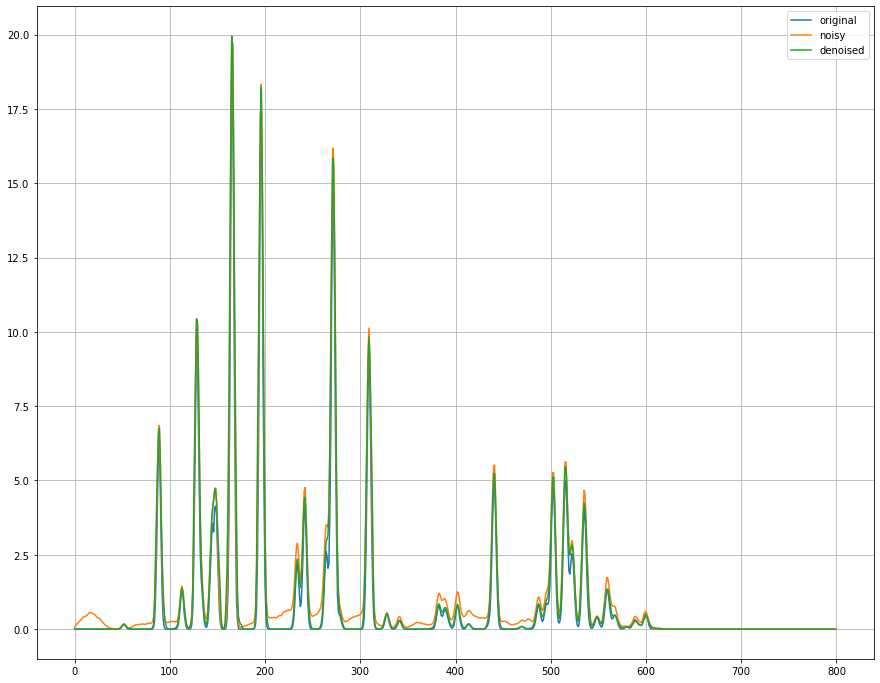

In [29]:
plt.rcParams["figure.figsize"]=(15, 12)
plt.plot(sigmap.mean(axis = 0), label = 'original')
plt.plot(patterns.mean(axis = 0) * (1 + noise_scale), label = 'noisy')
plt.plot(denoised.mean(axis = 0) * (1 + noise_scale), label = 'denoised')
plt.grid()
plt.legend()

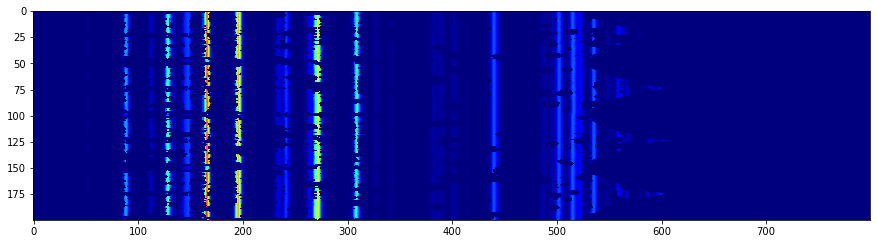

In [30]:
plt.imshow((~mask) * patterns, cmap = 'jet', interpolation='none')